In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# Set random seed
seed = 0



In [13]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_encoded.csv', sep='|')

In [14]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Columns: 735 entries, num__budget to category
dtypes: float64(734), object(1)
memory usage: 49.3+ MB
None
   num__budget  num__revenue  num__popularity  num__runtime  num__vote_count  \
0     4.757463      1.005269         0.425819      0.448734         1.716450   
1     2.894642      1.159981         0.366180     -0.230573         1.636140   
2     3.826052      2.100421         0.503760      0.739865         1.420090   
3     2.628524      0.670763         0.183190     -0.230573         1.375134   
4     1.510832      0.743000         0.159881     -0.085007         0.961366   

   num__release_year  num__release_month  cat__original_language_ar  \
0           0.483259           -0.241059                        0.0   
1           0.605583           -0.533445                        0.0   
2           0.789068           -0.241059                        0.0   
3           0.727906            0.343713               

# Scoring prediction

In [15]:
desired_order = ['bad', 'mediocre', 'good', 'great']
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(desired_order)
df['category'] = label_encoder.transform(df['category'])

In [16]:
X = df.drop('category', axis=1)
Y = df['category']

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


## Random Forest

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)

rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=0)

In [19]:
Y_pred = rf_model.predict(X_test)

In [20]:
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6870


In [23]:
print(classification_report(Y_test, Y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         bad       0.90      0.79      0.84       450
    mediocre       0.61      0.66      0.63       448
        good       0.55      0.61      0.57       430
       great       0.74      0.69      0.72       429

    accuracy                           0.69      1757
   macro avg       0.70      0.69      0.69      1757
weighted avg       0.70      0.69      0.69      1757



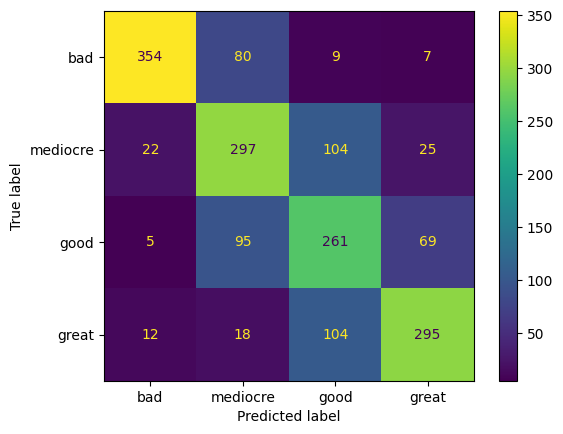

In [25]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()

In [26]:
all_feature_names = X.columns

# Ensure that all_feature_names length matches feature_importances length
# This assumes that you have fitted the Random Forest model and have access to its feature importances
# Replace `rf_model` with your actual Random Forest model instance

print(f"Length of feature names: {len(all_feature_names)}")
print(f"Length of feature importances: {len(rf_model.feature_importances_)}")

# Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model.feature_importances_
})

# Sort the DataFrame by feature importance
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the result
print(feature_importances_df)

Length of feature names: 734
Length of feature importances: 734
                               feature  importance
4                      num__vote_count    0.135524
2                      num__popularity    0.057478
3                         num__runtime    0.050792
5                    num__release_year    0.049836
1                         num__revenue    0.043046
..                                 ...         ...
536  production_countries__philippines    0.000000
471          production_countries__and    0.000000
479      production_countries__bahamas    0.000000
565    production_countries__venezuela    0.000000
30           cat__original_language_nb    0.000000

[734 rows x 2 columns]


In [27]:
# Print 50 most important features that contain 'cast'
print(feature_importances_df[feature_importances_df['feature'].str.startswith('cast')].head(10))

                feature  importance
593   cast__frankwelker    0.000774
607     cast__jimmystar    0.000697
619   cast__keanureeves    0.000664
663   cast__willemdafoe    0.000599
656  cast__stevenseagal    0.000594
599       cast__jackson    0.000568
608         cast__johnc    0.000568
647       cast__samuell    0.000549
613    cast__johnnydepp    0.000502
581   cast__brucewillis    0.000493


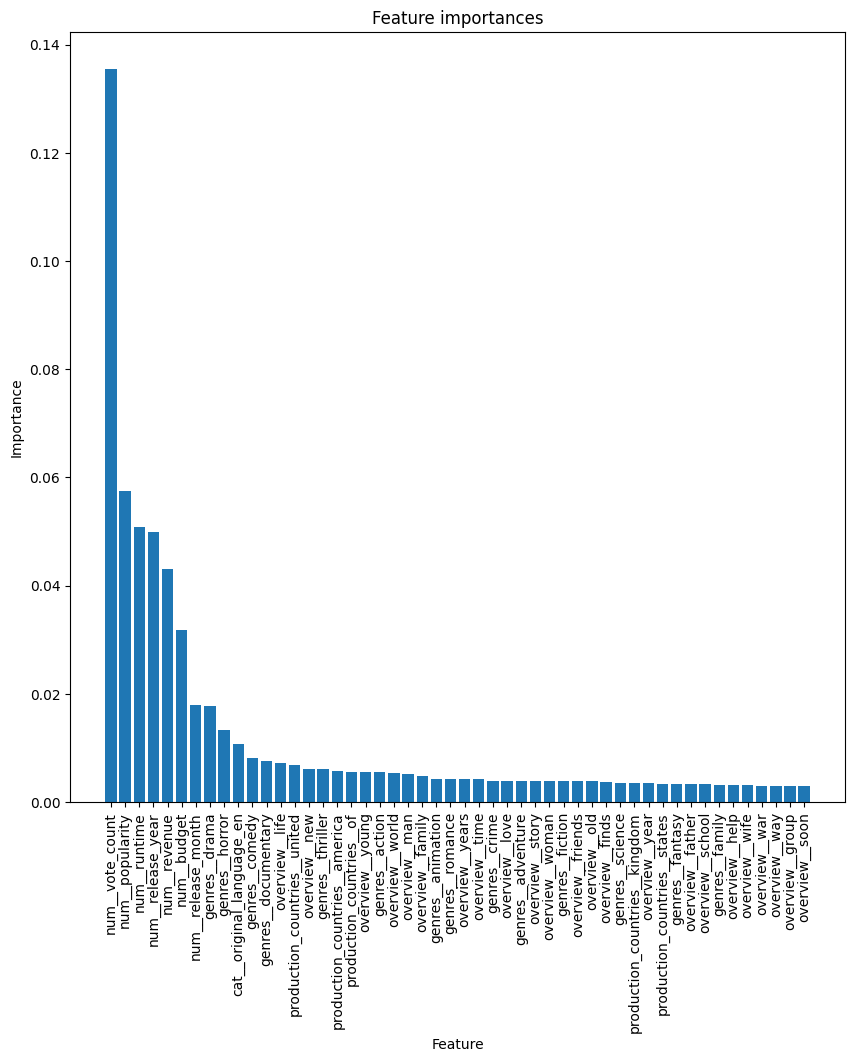

In [28]:
# plot as bars first 50 feature importances
plt.figure(figsize=(10, 10))
plt.bar(range(50), feature_importances_df['importance'][:50], align='center')
plt.xticks(range(50), feature_importances_df['feature'][:50], rotation=90)
plt.title('Feature importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

#### Wrapper to tune parameters - GridSearch

In [29]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['sqrt', 'log2'],          
    'max_depth': [10, 20, 50, None],                   
    'min_samples_split': [2, 5, 10],                    
    'min_samples_leaf': [1, 2, 4],                     
    'bootstrap': [True, False]                         
}

In [30]:
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    scoring='accuracy', 
    cv=5, 
    verbose=2, 
    n_jobs=-1
)

In [32]:
grid_search.fit(X_train, Y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

/usr/local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  10.9s
[CV] END bootstrap=True, max_depth

In [33]:
best_rf_model = grid_search.best_estimator_
Y_pred = best_rf_model.predict(X_test)

In [34]:
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7080


In [35]:
print(classification_report(Y_test, Y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         bad       0.94      0.78      0.86       450
    mediocre       0.62      0.70      0.66       448
        good       0.58      0.63      0.61       430
       great       0.75      0.71      0.73       429

    accuracy                           0.71      1757
   macro avg       0.72      0.71      0.71      1757
weighted avg       0.72      0.71      0.71      1757



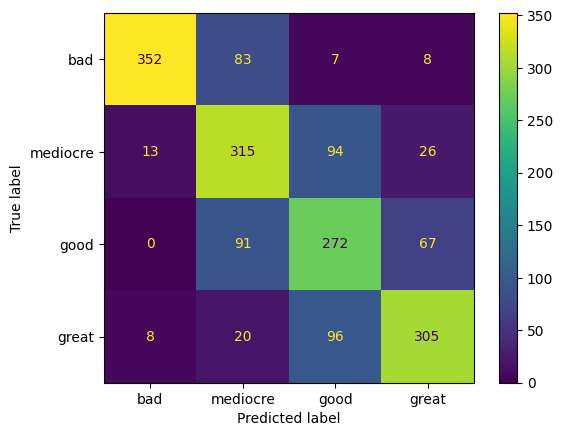

In [36]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()